# Model selection for knowledge graph embeddings

For hyperparameter optimisation random search is more optimal than grid search as the search space grows: *James Bergstra and Yoshua Bengio. Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(Feb):281–305, 2012.*

While this approach is not optimal, it is a strong baseline agains other more advanced methods such as Baysian optimisation: *Lisha Li and Kevin Jamieson. Hyperband: a novel bandit-based approach to hyperparameter optimization. Journal of Machine Learning Research, 18:1–52, 2018.*

In [29]:
import tensorflow as tf
import numpy as np
import pickle
np.random.seed(0)
import matplotlib as mpl
import matplotlib.pyplot  as plt


from ampligraph.evaluation import train_test_split_no_unseen 
from ampligraph.latent_features import RandomBaseline, TransE, DistMult, ComplEx, HolE, ConvE, ConvKB
from ampligraph.latent_features import save_model
from ampligraph.evaluation import evaluate_performance, select_best_model_ranking, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import save_model, restore_model

## Data retrieval

In [2]:
#data = np.loadtxt("family_subset.txt", dtype = 'object')

In [3]:
data = np.loadtxt("family_subset.txt", dtype = 'object')
X_train = data[:1000]
X_val = data[1000:1500]
X_test = data[1500:1900]

In [4]:
data.shape

(258235, 3)

## Metrics

In [5]:
test_metrics = {}

## Random Baseline
Random baseline requires no hyperparameter search as it assigns a pseudo-random score to triples.

In [6]:
model_class = RandomBaseline
param_grid = {
    "seed": 0
}
best_model, _, _, _, randomBaseline_mrr_test, _ = select_best_model_ranking(model_class, X_train, X_val, X_test,
                          param_grid,
                          max_combinations=1,
                          use_filter=True,
                          verbose=False,
                          early_stopping=False)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [7]:
test_metrics["RandomBaseline"] = randomBaseline_mrr_test
save_model(best_model, './trained_models/RandomBaseline.pkl')
del best_model

## TransE

In [8]:
model_class = TransE
param_grid = {
    "batches_count": [50],
    "seed": 0,
     "epochs": [10],
     "k": [100, 200],
     "eta": [5, 10, 15],
     "loss": ["pairwise", "nll"],
     "loss_params": {
         "margin": [2]
     },
     "embedding_model_params": {
     },
     "regularizer": ["LP", None],
     "regularizer_params": {
         "p": [1, 3],
         "lambda": [1e-4, 1e-5]
     },
     "optimizer": ["adagrad", "adam"],
     "optimizer_params": {
         "lr": lambda: np.random.uniform(0.0001, 0.01)
     },
     "verbose": False
}

In [9]:
best_model, _, _, _, transE_mrr_test, _ = select_best_model_ranking(model_class, X_train, X_val, X_test,
                          param_grid,
                          max_combinations=6,
                          use_filter=True,
                          verbose=False,
                          early_stopping=False)

In [10]:
save_model(best_model, './trained_models/TransE.pkl')
test_metrics["TransE"] = transE_mrr_test
del best_model

## Distmult

In [11]:
model_class = DistMult
param_grid = {
    "batches_count": [50],
    "seed": 0,
    "epochs": [10],
    "k": [100, 200],
    "eta": [5, 10, 15],
    "loss": ["pairwise", "nll"],
    "loss_params": {
        "margin": [2]
    },
    "embedding_model_params": {
        
    },
    "regularizer": ["LP", None],
    "regularizer_params": {
        "p": [1, 3],
        "lambda": [1e-4, 1e-5]
    },
    "optimizer": ["adagrad", "adam"],
    "optimizer_params": {
        "lr": lambda: np.random.uniform(0.0001, 0.01)
    },
    "verbose": True
}

In [12]:
best_model, _, _, _, distMult_mrr_test, _ = select_best_model_ranking(model_class, X_train, X_val, X_test,
                          param_grid,
                          max_combinations=6,
                          use_filter=True,
                          verbose=False,
                          early_stopping=False)

100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 189.44it/s]


In [13]:
save_model(best_model, './trained_models/DistMult.pkl')
test_metrics["DistMult"] = distMult_mrr_test
del best_model

## ComplEx

In [14]:
model_class = ComplEx
param_grid = {
    "batches_count": [50],
    "seed": 0,
    "epochs": [10],
    "k": [100, 200],
    "eta": [5, 10, 15],
    "loss": ["pairwise", "nll"],
    "loss_params": {
        "margin": [2]
    },
    "embedding_model_params": {
        
    },
    "regularizer": ["LP", None],
    "regularizer_params": {
        "p": [1, 3],
        "lambda": [1e-4, 1e-5]
    },
    "optimizer": ["adagrad", "adam"],
    "optimizer_params": {
        "lr": lambda: np.random.uniform(0.0001, 0.01)
    },
    "verbose": True
}

In [15]:
best_model, _, _, _, complEx_mrr_test, _ = select_best_model_ranking(model_class, X_train, X_val, X_test,
                          param_grid,
                          max_combinations=6,
                          use_filter=True,
                          verbose=False,
                          early_stopping=False)

100%|██████████████████████████████████████████| 57/57 [00:01<00:00, 55.14it/s]


In [17]:
save_model(best_model, './trained_models/ComplEx.pkl')
test_metrics["ComplEx"] = complEx_mrr_test
#del best_model

## View test metrics

In [19]:
# save test metrics to file
file = open("test_metrics.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(test_metrics,file)

# close file
file.close()

In [18]:
test_metrics

{'RandomBaseline': {'mrr': 0.0025414034914838556,
  'mr': 687.5,
  'hits_1': 0.0,
  'hits_3': 0.0,
  'hits_10': 0.0},
 'TransE': {'mrr': 0.04500424337819401,
  'mr': 67.70175438596492,
  'hits_1': 0.0,
  'hits_3': 0.03508771929824561,
  'hits_10': 0.06140350877192982},
 'DistMult': {'mrr': 0.024709890573435384,
  'mr': 491.67543859649123,
  'hits_1': 0.017543859649122806,
  'hits_3': 0.02631578947368421,
  'hits_10': 0.02631578947368421},
 'ComplEx': {'mrr': 0.0676401615558213,
  'mr': 241.1578947368421,
  'hits_1': 0.017543859649122806,
  'hits_3': 0.07017543859649122,
  'hits_10': 0.17543859649122806}}

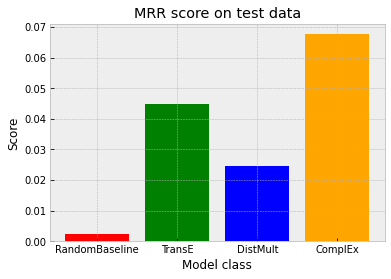

In [56]:
# Histogram
names = ["RandomBaseline", "TransE", "DistMult", "ComplEx"]
values = [list(test_metrics["RandomBaseline"].values())[0], 
          list(test_metrics["TransE"].values())[0], 
          list(test_metrics["DistMult"].values())[0], 
          list(test_metrics["ComplEx"].values())[0]]
plt.bar(names, values, color=['red', 'green', 'blue', 'orange'])
plt.ylabel('Score')
plt.xlabel('Model class')
plt.title("MRR score on test data");

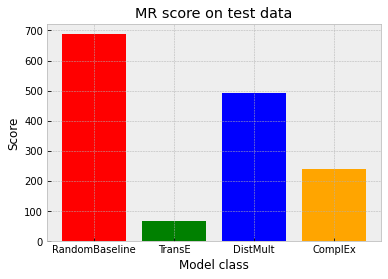

In [57]:
# Histogram
names = ["RandomBaseline", "TransE", "DistMult", "ComplEx"]
values = [list(test_metrics["RandomBaseline"].values())[1], 
          list(test_metrics["TransE"].values())[1], 
          list(test_metrics["DistMult"].values())[1], 
          list(test_metrics["ComplEx"].values())[1]]
plt.bar(names, values, color=['red', 'green', 'blue', 'orange'])
plt.ylabel('Score')
plt.xlabel('Model class')
plt.title("MR score on test data");

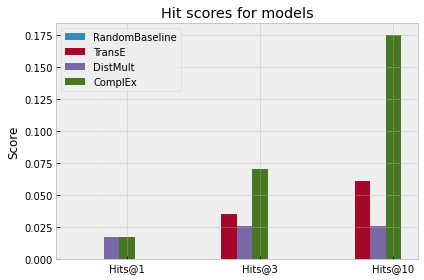

In [58]:
labels = ['Hits@1','Hits@3','Hits@10']
metrics_RandomBaseline = list(test_metrics["RandomBaseline"].values())[2:5]
metrics_TransE = list(test_metrics["TransE"].values())[2:5]
metrics_DistMult = list(test_metrics["DistMult"].values())[2:5]
metrics_ComplEx = list(test_metrics["ComplEx"].values())[2:5]


x = (np.arange(len(labels)))*3  # the label locations
width = 0.35  # the width of the bars
mpl.style.use("bmh")
fig, ax = plt.subplots()
bar_C11 = ax.bar(x - 3*(width), metrics_RandomBaseline, width, label='RandomBaseline')
bar_C12 = ax.bar(x - 2*(width), metrics_TransE, width, label='TransE')
bar_C21 = ax.bar(x - width, metrics_DistMult, width, label='DistMult')
bar_C22 = ax.bar(x, metrics_ComplEx, width, label='ComplEx')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Hit scores for models')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()
plt.show()